**16장 – RNN과 어텐션을 사용한 자연어 처리**

_이 노트북은 16장에 있는 모든 샘플 코드를 담고 있습니다._

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/handson-ml2/blob/master/16_nlp_with_rnns_and_attention.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

# 설정

먼저 몇 개의 모듈을 임포트합니다. 맷플롯립 그래프를 인라인으로 출력하도록 만들고 그림을 저장하는 함수를 준비합니다. 또한 파이썬 버전이 3.5 이상인지 확인합니다(파이썬 2.x에서도 동작하지만 곧 지원이 중단되므로 파이썬 3을 사용하는 것이 좋습니다). 사이킷런 버전이 0.20 이상인지와 텐서플로 버전이 2.0 이상인지 확인합니다.

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version은 코랩에서만 동작합니다.
    %tensorflow_version 2.x
    %pip install -q -U tensorflow-addons
    %pip install -q -U transformers
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# 텐서플로 ≥2.0 필수
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("감지된 GPU가 없습니다. GPU가 없으면 LSTM과 CNN이 매우 느릴 수 있습니다.")
    if IS_COLAB:
        print("런타임 > 런타임 유형 변경 메뉴를 선택하고 하드웨어 가속기로 GPU를 고르세요.")

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)
tf.random.set_seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "nlp"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

     |████████████████████████████████| 1.1 MB 3.2 MB/s 
     |████████████████████████████████| 2.6 MB 4.0 MB/s 
     |████████████████████████████████| 895 kB 71.1 MB/s 
     |████████████████████████████████| 3.3 MB 20.5 MB/s 
     |████████████████████████████████| 636 kB 67.3 MB/s 


# Char-RNN

## 시퀀스를 셔플 윈도우 배치로 나누기

예를 들어, 0~14까지 시퀀스를 2개씩 이동하면서 길이가 5인 윈도우로 나누어 보죠(가령,`[0, 1, 2, 3, 4]`, `[2, 3, 4, 5, 6]`, 등). 그다음 이를 섞고 입력(처음 네 개의 스텝)과 타깃(마지막 네 개의 스텝)으로 나눕니다(즉, `[2, 3, 4, 5, 6]`를 `[[2, 3, 4, 5], [3, 4, 5, 6]]`로 나눕니다). 그다음 입력/타깃 쌍 세 개로 구성된 배치를 만듭니다:

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

n_steps = 5
dataset = tf.data.Dataset.from_tensor_slices(tf.range(15))
dataset = dataset.window(n_steps, shift=2, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(n_steps))
dataset = dataset.shuffle(10).map(lambda window: (window[:-1], window[1:]))
dataset = dataset.batch(3).prefetch(1)
for index, (X_batch, Y_batch) in enumerate(dataset):
    print("_" * 20, "Batch", index, "\nX_batch")
    print(X_batch.numpy())
    print("=" * 5, "\nY_batch")
    print(Y_batch.numpy())

____________________ Batch 0 
X_batch
[[6 7 8 9]
 [2 3 4 5]
 [4 5 6 7]]
===== 
Y_batch
[[ 7  8  9 10]
 [ 3  4  5  6]
 [ 5  6  7  8]]
____________________ Batch 1 
X_batch
[[ 0  1  2  3]
 [ 8  9 10 11]
 [10 11 12 13]]
===== 
Y_batch
[[ 1  2  3  4]
 [ 9 10 11 12]
 [11 12 13 14]]


## 데이터 로드하고 데이터셋 준비하기

In [3]:
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
filepath = keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()

1130496/1115394 [==============================] - 0s 0us/step


In [4]:
print(shakespeare_text[:148])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?



In [5]:
"".join(sorted(set(shakespeare_text.lower())))

"\n !$&',-.3:;?abcdefghijklmnopqrstuvwxyz"

In [6]:
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(shakespeare_text)

In [7]:
tokenizer.texts_to_sequences(["First"])

[[20, 6, 9, 8, 3]]

In [8]:
tokenizer.sequences_to_texts([[20, 6, 9, 8, 3]])

['f i r s t']

In [9]:
max_id = len(tokenizer.word_index) # 고유한 문자 개수
dataset_size = tokenizer.document_count # 전체 문자 개수

In [10]:
[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1
train_size = dataset_size * 90 // 100
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

**노트**: 예전 코드에서는 `dataset.repeat()`를 사용해 데이터셋을 무한하게 반복할 수 있게 만들고 나중에 `model.fit()` 메서드를 호출할 때 `steps_per_epoch` 매개변수를 지정했습니다. 텐서플로 버그 때문에 이렇게 해야 했지만 이제는 수정되었기 때문에 코드를 간단하게 만들 수 있습니다. `dataset.repeat()`와 `steps_per_epoch`가 더 이상 필요하지 않습니다.

In [11]:
n_steps = 100
window_length = n_steps + 1 # 타깃 = 한 글자 앞선 입력
dataset = dataset.window(window_length, shift=1, drop_remainder=True)

In [12]:
dataset = dataset.flat_map(lambda window: window.batch(window_length))

In [13]:
np.random.seed(42)
tf.random.set_seed(42)

In [14]:
batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))

In [15]:
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))

In [16]:
dataset = dataset.prefetch(1)

In [17]:
for X_batch, Y_batch in dataset.take(1):
    print(X_batch.shape, Y_batch.shape)

(32, 100, 39) (32, 100)


## 모델 만들고 훈련하기

**경고**: 다음 코드는 하드웨어에 따라 실행하는데 24시간이 걸릴 수 있습니다. GPU를 사용하면 1~2시간 정도 걸릴 수 있습니다.

**노트**: `GRU` 클래스는 다음 매개변수에서 기본값을 사용할 때에만 GPU를 사용합니다: `activation`, `recurrent_activation`, `recurrent_dropout`, `unroll`, `use_bias` `reset_after`. 이 때문에 (책과는 달리) `recurrent_dropout=0.2`를 주석 처리했습니다.

In [18]:
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id],
                     #dropout=0.2, recurrent_dropout=0.2),
                     dropout=0.2),
    keras.layers.GRU(128, return_sequences=True,
                     #dropout=0.2, recurrent_dropout=0.2),
                     dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
history = model.fit(dataset, epochs=10)

Epoch 1/10
31368/31368 [==============================] - 376s 12ms/step - loss: 1.6206
Epoch 2/10
31368/31368 [==============================] - 351s 11ms/step - loss: 1.5369
Epoch 3/10
31368/31368 [==============================] - 347s 11ms/step - loss: 1.5171
Epoch 4/10
31368/31368 [==============================] - 344s 11ms/step - loss: 1.5053
Epoch 5/10
31368/31368 [==============================] - 346s 11ms/step - loss: 1.4980
Epoch 6/10
31368/31368 [==============================] - 344s 11ms/step - loss: 1.4927
Epoch 7/10
31368/31368 [==============================] - 344s 11ms/step - loss: 1.4891
Epoch 8/10
31368/31368 [==============================] - 347s 11ms/step - loss: 1.4864
Epoch 9/10
31368/31368 [==============================] - 345s 11ms/step - loss: 1.4842
Epoch 10/10
31368/31368 [==============================] - 346s 11ms/step - loss: 1.4821


## 모델로 텍스트 생성하기

In [19]:
def preprocess(texts):
    X = np.array(tokenizer.texts_to_sequences(texts)) - 1
    return tf.one_hot(X, max_id)

**경고**: `predict_classes()` 메서드는 deprecated 되었습니다. 대신 `np.argmax(model(X_new), axis=-1)`를 사용합니다.

In [20]:
X_new = preprocess(["How are yo"])
#Y_pred = model.predict_classes(X_new)
Y_pred = np.argmax(model(X_new), axis=-1)
tokenizer.sequences_to_texts(Y_pred + 1)[0][-1] # 1st sentence, last char

'u'

In [21]:
tf.random.set_seed(42)

tf.random.categorical([[np.log(0.5), np.log(0.4), np.log(0.1)]], num_samples=40).numpy()

array([[0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
        2, 0, 0, 1, 1, 1, 0, 0, 1, 2, 0, 0, 1, 1, 0, 0, 0, 0]])

In [22]:
def next_char(text, temperature=1):
    X_new = preprocess([text])
    y_proba = model(X_new)[0, -1:, :]
    rescaled_logits = tf.math.log(y_proba) / temperature
    char_id = tf.random.categorical(rescaled_logits, num_samples=1) + 1
    return tokenizer.sequences_to_texts(char_id.numpy())[0]

In [23]:
tf.random.set_seed(42)

next_char("How are yo", temperature=1)

'u'

In [24]:
def complete_text(text, n_chars=50, temperature=1):
    for _ in range(n_chars):
        text += next_char(text, temperature)
    return text

In [25]:
tf.random.set_seed(42)

print(complete_text("t", temperature=0.2))

the maid in padua for my father is a stood
and so m


In [26]:
print(complete_text("t", temperature=1))

toke on advised in sobel countryman,
and signior gr


In [27]:
print(complete_text("t", temperature=2))

tpeniomently!
well maze: yet 'pale deficuruli-faeem


## 상태가 있는 RNN

In [28]:
tf.random.set_seed(42)

In [29]:
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])
dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(window_length))
dataset = dataset.batch(1)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)

In [30]:
batch_size = 32
encoded_parts = np.array_split(encoded[:train_size], batch_size)
datasets = []
for encoded_part in encoded_parts:
    dataset = tf.data.Dataset.from_tensor_slices(encoded_part)
    dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_length))
    datasets.append(dataset)
dataset = tf.data.Dataset.zip(tuple(datasets)).map(lambda *windows: tf.stack(windows))
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)

**노트**: 여기에서도 GPU 가속을 위해 (책과 달리) `recurrent_dropout=0.2`을 주석 처리합니다.

In [31]:
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, stateful=True,
                     #dropout=0.2, recurrent_dropout=0.2,
                     dropout=0.2,
                     batch_input_shape=[batch_size, None, max_id]),
    keras.layers.GRU(128, return_sequences=True, stateful=True,
                     #dropout=0.2, recurrent_dropout=0.2),
                     dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])

In [32]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [33]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
history = model.fit(dataset, epochs=50,
                    callbacks=[ResetStatesCallback()])

Epoch 1/50
313/313 [==============================] - 6s 12ms/step - loss: 2.6200
Epoch 2/50
313/313 [==============================] - 4s 12ms/step - loss: 2.2410
Epoch 3/50
313/313 [==============================] - 4s 12ms/step - loss: 2.1105
Epoch 4/50
313/313 [==============================] - 4s 12ms/step - loss: 2.0368
Epoch 5/50
313/313 [==============================] - 4s 12ms/step - loss: 1.9860
Epoch 6/50
313/313 [==============================] - 4s 12ms/step - loss: 1.9488
Epoch 7/50
313/313 [==============================] - 4s 12ms/step - loss: 1.9205
Epoch 8/50
313/313 [==============================] - 4s 12ms/step - loss: 1.8985
Epoch 9/50
313/313 [==============================] - 4s 12ms/step - loss: 1.8797
Epoch 10/50
313/313 [==============================] - 4s 12ms/step - loss: 1.8655
Epoch 11/50
313/313 [==============================] - 4s 12ms/step - loss: 1.8533
Epoch 12/50
313/313 [==============================] - 4s 12ms/step - loss: 1.8412
Epoch 13/50
3

모델에 다른 크기의 배치를 사용하려면 상태가 없는 복사본을 만들어야 합니다. 드롭아웃은 훈련에만 사용되기 때문에 삭제합니다:

In [34]:
stateless_model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id]),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])

가중치를 복사하려면 먼저 (가중치를 만들기 위해) 모델을 빌드합니다:

In [35]:
stateless_model.build(tf.TensorShape([None, None, max_id]))

In [36]:
stateless_model.set_weights(model.get_weights())
model = stateless_model

In [37]:
tf.random.set_seed(42)

print(complete_text("t"))

thing idsumper your shint.
why, he has go too stone


# 감성 분석

In [38]:
tf.random.set_seed(42)

IMDB 데이터셋을 로드합니다:

In [39]:
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data()

17473536/17464789 [==============================] - 0s 0us/step


In [40]:
X_train[0][:10]

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]

In [41]:
word_index = keras.datasets.imdb.get_word_index()
id_to_word = {id_ + 3: word for word, id_ in word_index.items()}
for id_, token in enumerate(("<pad>", "<sos>", "<unk>")):
    id_to_word[id_] = token
" ".join([id_to_word[id_] for id_ in X_train[0][:10]])

1654784/1641221 [==============================] - 0s 0us/step


'<sos> this film was just brilliant casting location scenery story'

In [42]:
import tensorflow_datasets as tfds

datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteAII20M/imdb_reviews-train.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteAII20M/imdb_reviews-test.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteAII20M/imdb_reviews-unsupervised.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [43]:
datasets.keys()

dict_keys(['test', 'train', 'unsupervised'])

In [44]:
train_size = info.splits["train"].num_examples
test_size = info.splits["test"].num_examples

In [45]:
train_size, test_size

(25000, 25000)

In [46]:
for X_batch, y_batch in datasets["train"].batch(2).take(1):
    for review, label in zip(X_batch.numpy(), y_batch.numpy()):
        print("Review:", review.decode("utf-8")[:200], "...")
        print("Label:", label, "= Positive" if label else "= Negative")
        print()

Review: This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting  ...
Label: 0 = Negative

Review: I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However  ...
Label: 0 = Negative



In [47]:
def preprocess(X_batch, y_batch):
    X_batch = tf.strings.substr(X_batch, 0, 300)
    X_batch = tf.strings.regex_replace(X_batch, rb"<br\s*/?>", b" ")
    X_batch = tf.strings.regex_replace(X_batch, b"[^a-zA-Z']", b" ")
    X_batch = tf.strings.split(X_batch)
    return X_batch.to_tensor(default_value=b"<pad>"), y_batch

In [48]:
preprocess(X_batch, y_batch)

(<tf.Tensor: shape=(2, 53), dtype=string, numpy=
 array([[b'This', b'was', b'an', b'absolutely', b'terrible', b'movie',
         b"Don't", b'be', b'lured', b'in', b'by', b'Christopher',
         b'Walken', b'or', b'Michael', b'Ironside', b'Both', b'are',
         b'great', b'actors', b'but', b'this', b'must', b'simply', b'be',
         b'their', b'worst', b'role', b'in', b'history', b'Even',
         b'their', b'great', b'acting', b'could', b'not', b'redeem',
         b'this', b"movie's", b'ridiculous', b'storyline', b'This',
         b'movie', b'is', b'an', b'early', b'nineties', b'US',
         b'propaganda', b'pi', b'<pad>', b'<pad>', b'<pad>'],
        [b'I', b'have', b'been', b'known', b'to', b'fall', b'asleep',
         b'during', b'films', b'but', b'this', b'is', b'usually', b'due',
         b'to', b'a', b'combination', b'of', b'things', b'including',
         b'really', b'tired', b'being', b'warm', b'and', b'comfortable',
         b'on', b'the', b'sette', b'and', b'having', b'j

In [49]:
from collections import Counter

vocabulary = Counter()
for X_batch, y_batch in datasets["train"].batch(32).map(preprocess):
    for review in X_batch:
        vocabulary.update(list(review.numpy()))

In [50]:
vocabulary.most_common()[:3]

[(b'<pad>', 214309), (b'the', 61137), (b'a', 38564)]

In [51]:
len(vocabulary)

53893

In [52]:
vocab_size = 10000
truncated_vocabulary = [
    word for word, count in vocabulary.most_common()[:vocab_size]]

In [53]:
word_to_id = {word: index for index, word in enumerate(truncated_vocabulary)}
for word in b"This movie was faaaaaantastic".split():
    print(word_to_id.get(word) or vocab_size)

22
12
11
10000


In [54]:
words = tf.constant(truncated_vocabulary)
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
num_oov_buckets = 1000
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

In [55]:
table.lookup(tf.constant([b"This movie was faaaaaantastic".split()]))

<tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[   22,    12,    11, 10053]])>

In [56]:
def encode_words(X_batch, y_batch):
    return table.lookup(X_batch), y_batch

train_set = datasets["train"].batch(32).map(preprocess)
train_set = train_set.map(encode_words).prefetch(1)

In [57]:
for X_batch, y_batch in train_set.take(1):
    print(X_batch)
    print(y_batch)

tf.Tensor(
[[  22   11   28 ...    0    0    0]
 [   6   21   70 ...    0    0    0]
 [4099 6881    1 ...    0    0    0]
 ...
 [  22   12  118 ...  331 1047    0]
 [1757 4101  451 ...    0    0    0]
 [3365 4392    6 ...    0    0    0]], shape=(32, 60), dtype=int64)
tf.Tensor([0 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 1 1 1 0 1 1 1 1 1 0 0 0 1 0 0 0], shape=(32,), dtype=int64)


In [58]:
embed_size = 128
model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size,
                           mask_zero=True, # not shown in the book
                           input_shape=[None]),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.GRU(128),
    keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_set, epochs=5)

Epoch 1/5
782/782 [==============================] - 18s 16ms/step - loss: 0.5305 - accuracy: 0.7281
Epoch 2/5
782/782 [==============================] - 12s 16ms/step - loss: 0.3459 - accuracy: 0.8549
Epoch 3/5
782/782 [==============================] - 12s 16ms/step - loss: 0.1934 - accuracy: 0.9313
Epoch 4/5
782/782 [==============================] - 12s 16ms/step - loss: 0.1361 - accuracy: 0.9503
Epoch 5/5
782/782 [==============================] - 12s 16ms/step - loss: 0.1032 - accuracy: 0.9634


또는 직접 마스킹을 합니다:

In [59]:
K = keras.backend
embed_size = 128
inputs = keras.layers.Input(shape=[None])
mask = keras.layers.Lambda(lambda inputs: K.not_equal(inputs, 0))(inputs)
z = keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size)(inputs)
z = keras.layers.GRU(128, return_sequences=True)(z, mask=mask)
z = keras.layers.GRU(128)(z, mask=mask)
outputs = keras.layers.Dense(1, activation="sigmoid")(z)
model = keras.models.Model(inputs=[inputs], outputs=[outputs])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_set, epochs=5)

Epoch 1/5
782/782 [==============================] - 18s 15ms/step - loss: 0.5426 - accuracy: 0.7156
Epoch 2/5
782/782 [==============================] - 12s 16ms/step - loss: 0.3469 - accuracy: 0.8572
Epoch 3/5
782/782 [==============================] - 12s 16ms/step - loss: 0.1753 - accuracy: 0.9384
Epoch 4/5
782/782 [==============================] - 12s 16ms/step - loss: 0.1274 - accuracy: 0.9542
Epoch 5/5
782/782 [==============================] - 12s 16ms/step - loss: 0.1131 - accuracy: 0.9577


## 사전 훈련된 임베딩 재사용하기

In [60]:
tf.random.set_seed(42)

In [61]:
TFHUB_CACHE_DIR = os.path.join(os.curdir, "my_tfhub_cache")
os.environ["TFHUB_CACHE_DIR"] = TFHUB_CACHE_DIR

In [62]:
import tensorflow_hub as hub

model = keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1",
                   dtype=tf.string, input_shape=[], output_shape=[50]),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])

In [63]:
for dirpath, dirnames, filenames in os.walk(TFHUB_CACHE_DIR):
    for filename in filenames:
        print(os.path.join(dirpath, filename))

./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe.descriptor.txt
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/saved_model.pb
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/assets/tokens.txt
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/variables/variables.index
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/variables/variables.data-00000-of-00001


In [64]:
import tensorflow_datasets as tfds

datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)
train_size = info.splits["train"].num_examples
batch_size = 32
train_set = datasets["train"].batch(batch_size).prefetch(1)
history = model.fit(train_set, epochs=5)

Epoch 1/5
782/782 [==============================] - 5s 5ms/step - loss: 0.5461 - accuracy: 0.7267
Epoch 2/5
782/782 [==============================] - 4s 5ms/step - loss: 0.5130 - accuracy: 0.7495
Epoch 3/5
782/782 [==============================] - 4s 5ms/step - loss: 0.5081 - accuracy: 0.7532
Epoch 4/5
782/782 [==============================] - 4s 5ms/step - loss: 0.5047 - accuracy: 0.7540
Epoch 5/5
782/782 [==============================] - 4s 5ms/step - loss: 0.5018 - accuracy: 0.7566


## 자동 번역

In [65]:
tf.random.set_seed(42)

In [66]:
vocab_size = 100
embed_size = 10

In [67]:
import tensorflow_addons as tfa

encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

embeddings = keras.layers.Embedding(vocab_size, embed_size)
encoder_embeddings = embeddings(encoder_inputs)
decoder_embeddings = embeddings(decoder_inputs)

encoder = keras.layers.LSTM(512, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]

sampler = tfa.seq2seq.sampler.TrainingSampler()

decoder_cell = keras.layers.LSTMCell(512)
output_layer = keras.layers.Dense(vocab_size)
decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell, sampler,
                                                 output_layer=output_layer)
final_outputs, final_state, final_sequence_lengths = decoder(
    decoder_embeddings, initial_state=encoder_state,
    sequence_length=sequence_lengths)
Y_proba = tf.nn.softmax(final_outputs.rnn_output)

model = keras.models.Model(
    inputs=[encoder_inputs, decoder_inputs, sequence_lengths],
    outputs=[Y_proba])

In [68]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")

In [69]:
X = np.random.randint(100, size=10*1000).reshape(1000, 10)
Y = np.random.randint(100, size=15*1000).reshape(1000, 15)
X_decoder = np.c_[np.zeros((1000, 1)), Y[:, :-1]]
seq_lengths = np.full([1000], 15)

history = model.fit([X, X_decoder, seq_lengths], Y, epochs=2)

Epoch 1/2
32/32 [==============================] - 4s 36ms/step - loss: 4.6054
Epoch 2/2
32/32 [==============================] - 1s 35ms/step - loss: 4.6031


### 양방향 순환층

In [70]:
model = keras.models.Sequential([
    keras.layers.GRU(10, return_sequences=True, input_shape=[None, 10]),
    keras.layers.Bidirectional(keras.layers.GRU(10, return_sequences=True))
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_10 (GRU)                 (None, None, 10)          660       
_________________________________________________________________
bidirectional (Bidirectional (None, None, 20)          1320      
Total params: 1,980
Trainable params: 1,980
Non-trainable params: 0
_________________________________________________________________


### 위치 인코딩

In [71]:
class PositionalEncoding(keras.layers.Layer):
    def __init__(self, max_steps, max_dims, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        if max_dims % 2 == 1: max_dims += 1 # max_dims must be even
        p, i = np.meshgrid(np.arange(max_steps), np.arange(max_dims // 2))
        pos_emb = np.empty((1, max_steps, max_dims))
        pos_emb[0, :, ::2] = np.sin(p / 10000**(2 * i / max_dims)).T
        pos_emb[0, :, 1::2] = np.cos(p / 10000**(2 * i / max_dims)).T
        self.positional_embedding = tf.constant(pos_emb.astype(self.dtype))
    def call(self, inputs):
        shape = tf.shape(inputs)
        return inputs + self.positional_embedding[:, :shape[-2], :shape[-1]]

In [72]:
max_steps = 201
max_dims = 512
pos_emb = PositionalEncoding(max_steps, max_dims)
PE = pos_emb(np.zeros((1, max_steps, max_dims), np.float32))[0].numpy()

Saving figure positional_embedding_plot


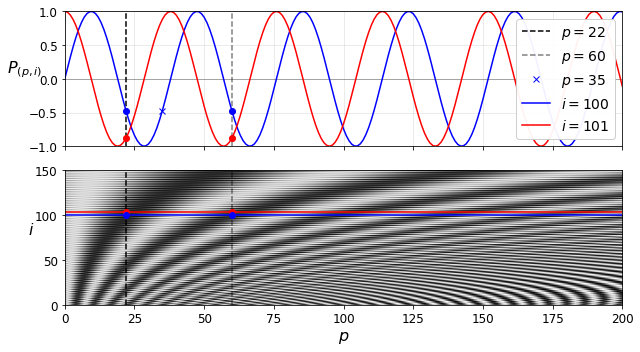

In [73]:
i1, i2, crop_i = 100, 101, 150
p1, p2, p3 = 22, 60, 35
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(9, 5))
ax1.plot([p1, p1], [-1, 1], "k--", label="$p = {}$".format(p1))
ax1.plot([p2, p2], [-1, 1], "k--", label="$p = {}$".format(p2), alpha=0.5)
ax1.plot(p3, PE[p3, i1], "bx", label="$p = {}$".format(p3))
ax1.plot(PE[:,i1], "b-", label="$i = {}$".format(i1))
ax1.plot(PE[:,i2], "r-", label="$i = {}$".format(i2))
ax1.plot([p1, p2], [PE[p1, i1], PE[p2, i1]], "bo")
ax1.plot([p1, p2], [PE[p1, i2], PE[p2, i2]], "ro")
ax1.legend(loc="center right", fontsize=14, framealpha=0.95)
ax1.set_ylabel("$P_{(p,i)}$", rotation=0, fontsize=16)
ax1.grid(True, alpha=0.3)
ax1.hlines(0, 0, max_steps - 1, color="k", linewidth=1, alpha=0.3)
ax1.axis([0, max_steps - 1, -1, 1])
ax2.imshow(PE.T[:crop_i], cmap="gray", interpolation="bilinear", aspect="auto")
ax2.hlines(i1, 0, max_steps - 1, color="b")
cheat = 2 # need to raise the red line a bit, or else it hides the blue one
ax2.hlines(i2+cheat, 0, max_steps - 1, color="r")
ax2.plot([p1, p1], [0, crop_i], "k--")
ax2.plot([p2, p2], [0, crop_i], "k--", alpha=0.5)
ax2.plot([p1, p2], [i2+cheat, i2+cheat], "ro")
ax2.plot([p1, p2], [i1, i1], "bo")
ax2.axis([0, max_steps - 1, 0, crop_i])
ax2.set_xlabel("$p$", fontsize=16)
ax2.set_ylabel("$i$", rotation=0, fontsize=16)
save_fig("positional_embedding_plot")
plt.show()

In [74]:
embed_size = 512; max_steps = 500; vocab_size = 10000
encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
embeddings = keras.layers.Embedding(vocab_size, embed_size)
encoder_embeddings = embeddings(encoder_inputs)
decoder_embeddings = embeddings(decoder_inputs)
positional_encoding = PositionalEncoding(max_steps, max_dims=embed_size)
encoder_in = positional_encoding(encoder_embeddings)
decoder_in = positional_encoding(decoder_embeddings)

다음은 (매우) 간소화한 Transformer입니다(실제 구조는 스킵 연결, 층 정규화, 밀집 층 그리고 가장 중요하게 일반적인 어텐션이 아니라 멀티-헤드 어텐션을 가집니다):

In [75]:
Z = encoder_in
for N in range(6):
    Z = keras.layers.Attention(use_scale=True)([Z, Z])

encoder_outputs = Z
Z = decoder_in
for N in range(6):
    Z = keras.layers.Attention(use_scale=True, causal=True)([Z, Z])
    Z = keras.layers.Attention(use_scale=True)([Z, encoder_outputs])

outputs = keras.layers.TimeDistributed(
    keras.layers.Dense(vocab_size, activation="softmax"))(Z)

다음은 기본적인 `MultiHeadAttention` 층의 구현입니다. 가까운 시일 내에 `keras.layers`에 추가될 것 같습니다. `kernel_size=1`인 (그리고 기본값 `padding="valid"`, `strides=1`을 사용하는) `Conv1D` 층은 `TimeDistributed(Dense(...))`과 같습니다.

In [76]:
K = keras.backend

class MultiHeadAttention(keras.layers.Layer):
    def __init__(self, n_heads, causal=False, use_scale=False, **kwargs):
        self.n_heads = n_heads
        self.causal = causal
        self.use_scale = use_scale
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.dims = batch_input_shape[0][-1]
        self.q_dims, self.v_dims, self.k_dims = [self.dims // self.n_heads] * 3 # could be hyperparameters instead
        self.q_linear = keras.layers.Conv1D(self.n_heads * self.q_dims, kernel_size=1, use_bias=False)
        self.v_linear = keras.layers.Conv1D(self.n_heads * self.v_dims, kernel_size=1, use_bias=False)
        self.k_linear = keras.layers.Conv1D(self.n_heads * self.k_dims, kernel_size=1, use_bias=False)
        self.attention = keras.layers.Attention(causal=self.causal, use_scale=self.use_scale)
        self.out_linear = keras.layers.Conv1D(self.dims, kernel_size=1, use_bias=False)
        super().build(batch_input_shape)
    def _multi_head_linear(self, inputs, linear):
        shape = K.concatenate([K.shape(inputs)[:-1], [self.n_heads, -1]])
        projected = K.reshape(linear(inputs), shape)
        perm = K.permute_dimensions(projected, [0, 2, 1, 3])
        return K.reshape(perm, [shape[0] * self.n_heads, shape[1], -1])
    def call(self, inputs):
        q = inputs[0]
        v = inputs[1]
        k = inputs[2] if len(inputs) > 2 else v
        shape = K.shape(q)
        q_proj = self._multi_head_linear(q, self.q_linear)
        v_proj = self._multi_head_linear(v, self.v_linear)
        k_proj = self._multi_head_linear(k, self.k_linear)
        multi_attended = self.attention([q_proj, v_proj, k_proj])
        shape_attended = K.shape(multi_attended)
        reshaped_attended = K.reshape(multi_attended, [shape[0], self.n_heads, shape_attended[1], shape_attended[2]])
        perm = K.permute_dimensions(reshaped_attended, [0, 2, 1, 3])
        concat = K.reshape(perm, [shape[0], shape_attended[1], -1])
        return self.out_linear(concat)

In [77]:
Q = np.random.rand(2, 50, 512)
V = np.random.rand(2, 80, 512)
multi_attn = MultiHeadAttention(8)
multi_attn([Q, V]).shape

TensorShape([2, 50, 512])

# 연습문제 해답

## 1. to 7.

부록 A 참조

## 8.
_연습문제: 호크라이터와 슈미트후버는 LSTM에 관한 [논문](https://homl.info/93)에서 임베딩된 레버 문법을 사용했습니다. 이는 ‘BPBTSXXVPSEPE’와 같은 문자열을 만드는 인공 문법입니다. 이 주제에 대한 제니 오어의 훌륭한 소개(https://homl.info/108)를 확인해보세요. 특정 임베딩된 레버 문법 하나를 선택하고(제니 오어의 페이지에 있는 것과 같은), 그다음에 문자열이 이 문법을 따르는지 아닌지 구별하는 RNN을 훈련해보세요. 먼저 문법에 맞는 문자열 50%와 그렇지 않은 문자열 50%를 담은 훈련 배치를 생성하는 함수를 만들어야 합니다._

먼저 문법에 맞는 문자열을 생성하는 함수가 필요합니다. 이 문법은 각 상태에서 가능한 전이 상태의 리스트입니다. 하나의 전이는 출력할 문자열(또는 생성할 문법)과 다음 상태를 지정합니다.

In [78]:
default_reber_grammar = [
    [("B", 1)],           # (state 0) =B=>(state 1)
    [("T", 2), ("P", 3)], # (state 1) =T=>(state 2) or =P=>(state 3)
    [("S", 2), ("X", 4)], # (state 2) =S=>(state 2) or =X=>(state 4)
    [("T", 3), ("V", 5)], # and so on...
    [("X", 3), ("S", 6)],
    [("P", 4), ("V", 6)],
    [("E", None)]]        # (state 6) =E=>(terminal state)

embedded_reber_grammar = [
    [("B", 1)],
    [("T", 2), ("P", 3)],
    [(default_reber_grammar, 4)],
    [(default_reber_grammar, 5)],
    [("T", 6)],
    [("P", 6)],
    [("E", None)]]

def generate_string(grammar):
    state = 0
    output = []
    while state is not None:
        index = np.random.randint(len(grammar[state]))
        production, state = grammar[state][index]
        if isinstance(production, list):
            production = generate_string(grammar=production)
        output.append(production)
    return "".join(output)

기본 레버 문법에 맞는 문자열을 몇 개 만들어 보겠습니다:

In [79]:
np.random.seed(42)

for _ in range(25):
    print(generate_string(default_reber_grammar), end=" ")

BTXXTTVPXTVPXTTVPSE BPVPSE BTXSE BPVVE BPVVE BTSXSE BPTVPXTTTVVE BPVVE BTXSE BTXXVPSE BPTTTTTTTTVVE BTXSE BPVPSE BTXSE BPTVPSE BTXXTVPSE BPVVE BPVVE BPVVE BPTTVVE BPVVE BPVVE BTXXVVE BTXXVVE BTXXVPXVVE 

좋습니다. 이제 임베딩된 레버 문법에 맞는 문자열을 몇 개 만들어 보겠습니다:

In [80]:
np.random.seed(42)

for _ in range(25):
    print(generate_string(embedded_reber_grammar), end=" ")

BTBPTTTVPXTVPXTTVPSETE BPBPTVPSEPE BPBPVVEPE BPBPVPXVVEPE BPBTXXTTTTVVEPE BPBPVPSEPE BPBTXXVPSEPE BPBTSSSSSSSXSEPE BTBPVVETE BPBTXXVVEPE BPBTXXVPSEPE BTBTXXVVETE BPBPVVEPE BPBPVVEPE BPBTSXSEPE BPBPVVEPE BPBPTVPSEPE BPBTXXVVEPE BTBPTVPXVVETE BTBPVVETE BTBTSSSSSSSXXVVETE BPBTSSSXXTTTTVPSEPE BTBPTTVVETE BPBTXXTVVEPE BTBTXSETE 

좋네요, 이제 이 문법을 따르지 않는 문자열을 생성할 함수를 만듭니다. 무작위하게 문자열을 만들 수 있지만 그렇게 하면 너무 문제가 쉬워지므로 대신 문법을 따르는 문자열을 만든 후 하나의 문자만 바꾸어 놓도록 하겠습니다:

In [81]:
POSSIBLE_CHARS = "BEPSTVX"

def generate_corrupted_string(grammar, chars=POSSIBLE_CHARS):
    good_string = generate_string(grammar)
    index = np.random.randint(len(good_string))
    good_char = good_string[index]
    bad_char = np.random.choice(sorted(set(chars) - set(good_char)))
    return good_string[:index] + bad_char + good_string[index + 1:]

잘못된 문자열 몇 개를 만들어 보죠:

In [82]:
np.random.seed(42)

for _ in range(25):
    print(generate_corrupted_string(embedded_reber_grammar), end=" ")

BTBPTTTPPXTVPXTTVPSETE BPBTXEEPE BPBPTVVVEPE BPBTSSSSXSETE BPTTXSEPE BTBPVPXTTTTTTEVETE BPBTXXSVEPE BSBPTTVPSETE BPBXVVEPE BEBTXSETE BPBPVPSXPE BTBPVVVETE BPBTSXSETE BPBPTTTPTTTTTVPSEPE BTBTXXTTSTVPSETE BBBTXSETE BPBTPXSEPE BPBPVPXTTTTVPXTVPXVPXTTTVVEVE BTBXXXTVPSETE BEBTSSSSSXXVPXTVVETE BTBXTTVVETE BPBTXSTPE BTBTXXTTTVPSBTE BTBTXSETX BTBTSXSSTE 

문자열을 바로 RNN에 주입할 수는 없기 때문에 어떤 식으로든 인코딩해야 합니다. 한 가지 방법은 각 문자를 원-핫 인코딩하는 것입니다. 또 다른 방식은 임베딩을 사용하는 것입니다. 두 번째 방법을 사용해 보겠습니다(문자 개수가 작다면 원-핫 인코딩도 좋은 선택일 것입니다). 임베딩을 위해 각 문자열을 문자 ID의 시퀀스로 바꾸어야 합니다. POSSIBLE_CHARS의 문자열 인덱스를 사용해 이런 작업을 수행하는 함수를 만들어 보겠습니다:

In [83]:
def string_to_ids(s, chars=POSSIBLE_CHARS):
    return [chars.index(c) for c in s]

In [84]:
string_to_ids("BTTTXXVVETE")

[0, 4, 4, 4, 6, 6, 5, 5, 1, 4, 1]

이제 50%는 올바른 문자열 50%는 잘못된 문자열로 이루어진 데이터셋을 만듭니다:

In [85]:
def generate_dataset(size):
    good_strings = [string_to_ids(generate_string(embedded_reber_grammar))
                    for _ in range(size // 2)]
    bad_strings = [string_to_ids(generate_corrupted_string(embedded_reber_grammar))
                   for _ in range(size - size // 2)]
    all_strings = good_strings + bad_strings
    X = tf.ragged.constant(all_strings, ragged_rank=1)
    y = np.array([[1.] for _ in range(len(good_strings))] +
                 [[0.] for _ in range(len(bad_strings))])
    return X, y

In [86]:
np.random.seed(42)

X_train, y_train = generate_dataset(10000)
X_valid, y_valid = generate_dataset(2000)

첫 번째 훈련 샘플을 확인해 보겠습니다:

In [87]:
X_train[0]

<tf.Tensor: shape=(22,), dtype=int32, numpy=
array([0, 4, 0, 2, 4, 4, 4, 5, 2, 6, 4, 5, 2, 6, 4, 4, 5, 2, 3, 1, 4, 1],
      dtype=int32)>

어떤 클래스에 속할까요?

In [88]:
y_train[0]

array([1.])

완벽합니다! 이제 올바른 문자열을 구분할 RNN을 만들 준비가 되었습니다. 간단한 시퀀스 이진 분류기를 만듭니다:

In [89]:
np.random.seed(42)
tf.random.set_seed(42)

embedding_size = 5

model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=[None], dtype=tf.int32, ragged=True),
    keras.layers.Embedding(input_dim=len(POSSIBLE_CHARS), output_dim=embedding_size),
    keras.layers.GRU(30),
    keras.layers.Dense(1, activation="sigmoid")
])
optimizer = keras.optimizers.SGD(learning_rate=0.02, momentum = 0.95, nesterov=True)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_6/gru_12/RaggedToTensor/boolean_mask_1/GatherV2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_6/gru_12/RaggedToTensor/boolean_mask/GatherV2:0", shape=(None, 5), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_6/gru_12/RaggedToTensor/Shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


313/313 [==============================] - 18s 53ms/step - loss: 0.6910 - accuracy: 0.5095 - val_loss: 0.6825 - val_accuracy: 0.5645
Epoch 2/20
313/313 [==============================] - 16s 52ms/step - loss: 0.6678 - accuracy: 0.5659 - val_loss: 0.6635 - val_accuracy: 0.6105
Epoch 3/20
313/313 [==============================] - 17s 53ms/step - loss: 0.6504 - accuracy: 0.5766 - val_loss: 0.6521 - val_accuracy: 0.6110
Epoch 4/20
313/313 [==============================] - 16s 52ms/step - loss: 0.6347 - accuracy: 0.5980 - val_loss: 0.6224 - val_accuracy: 0.6445
Epoch 5/20
313/313 [==============================] - 16s 52ms/step - loss: 0.6054 - accuracy: 0.6361 - val_loss: 0.5779 - val_accuracy: 0.6980
Epoch 6/20
313/313 [==============================] - 16s 52ms/step - loss: 0.5414 - accuracy: 0.7093 - val_loss: 0.4695 - val_accuracy: 0.7795
Epoch 7/20
313/313 [==============================] - 16s 52ms/step - loss: 0.3913 - accuracy: 0.8320 - val_loss: 0.2796 - val_accuracy: 0.8955
Epo

이제 두 개의 까다로운 문자열로 이 RNN을 테스트해 보죠: 첫 번째는 잘못된 것이고 두 번째는 올바른 것입니다. 이 문자열은 마지막에서 두 번째 글자만 다릅니다. RNN이 이를 맞춘다면 두 번째 문자가 항상 끝에서 두 번째 문자와 같아야 한다는 패턴을 알게 됐다는 것을 의미합니다. 이렇게 하려면 꽤 긴 단기 기억(long short-term memory)이 필요합니다(그래서 GRU 셀을 사용했습니다).

In [90]:
test_strings = ["BPBTSSSSSSSXXTTVPXVPXTTTTTVVETE",
                "BPBTSSSSSSSXXTTVPXVPXTTTTTVVEPE"]
X_test = tf.ragged.constant([string_to_ids(s) for s in test_strings], ragged_rank=1)

y_proba = model.predict(X_test)
print()
print("레버 문자열일 추정 확률:")
for index, string in enumerate(test_strings):
    print("{}: {:.2f}%".format(string, 100 * y_proba[index][0]))


Estimated probability that these are Reber strings:
BPBTSSSSSSSXXTTVPXVPXTTTTTVVETE: 0.06%
BPBTSSSSSSSXXTTVPXVPXTTTTTVVEPE: 91.51%


쨘! 잘 작동하네요. 이 RNN이 매우 높은 신뢰도로 정확한 답을 냈습니다. :)

## 9.
_연습문제: 날짜 문자열 포맷을 변환하는 인코더-디코더 모델을 훈련하세요(예를 들어, ‘April 22, 2019’에서 ‘2019-04-22’로 바꿉니다)._

먼저 데이터셋을 만들어 보죠. 1000-01-01 ~ 9999-12-31 사이의 랜덤한 날짜를 사용하겠습니다:

In [91]:
from datetime import date

# strftime()의 %B 포맷은 로케일에 의존하기 때문에 사용할 수 있습니다.
MONTHS = ["January", "February", "March", "April", "May", "June",
          "July", "August", "September", "October", "November", "December"]

def random_dates(n_dates):
    min_date = date(1000, 1, 1).toordinal()
    max_date = date(9999, 12, 31).toordinal()

    ordinals = np.random.randint(max_date - min_date, size=n_dates) + min_date
    dates = [date.fromordinal(ordinal) for ordinal in ordinals]

    x = [MONTHS[dt.month - 1] + " " + dt.strftime("%d, %Y") for dt in dates]
    y = [dt.isoformat() for dt in dates]
    return x, y

다음은 입력과 출력 형식에 맞춘 랜덤한 몇 개의 날짜입니다:

In [92]:
np.random.seed(42)

n_dates = 3
x_example, y_example = random_dates(n_dates)
print("{:25s}{:25s}".format("Input", "Target"))
print("-" * 50)
for idx in range(n_dates):
    print("{:25s}{:25s}".format(x_example[idx], y_example[idx]))

Input                    Target                   
--------------------------------------------------
September 20, 7075       7075-09-20               
May 15, 8579             8579-05-15               
January 11, 7103         7103-01-11               


입력에 가능한 전체 문자를 나열해 보죠:

In [93]:
INPUT_CHARS = "".join(sorted(set("".join(MONTHS) + "0123456789, ")))
INPUT_CHARS

' ,0123456789ADFJMNOSabceghilmnoprstuvy'

그리고 다음은 출력에 가능한 전체 문자입니다:

In [94]:
OUTPUT_CHARS = "0123456789-"

이전 연습문제에서처럼 문자열을 문자 ID 리스트로 바꾸는 함수를 작성해 보겠습니다:

In [95]:
def date_str_to_ids(date_str, chars=INPUT_CHARS):
    return [chars.index(c) for c in date_str]

In [96]:
date_str_to_ids(x_example[0], INPUT_CHARS)

[19, 23, 31, 34, 23, 28, 21, 23, 32, 0, 4, 2, 1, 0, 9, 2, 9, 7]

In [97]:
date_str_to_ids(y_example[0], OUTPUT_CHARS)

[7, 0, 7, 5, 10, 0, 9, 10, 2, 0]

In [98]:
def prepare_date_strs(date_strs, chars=INPUT_CHARS):
    X_ids = [date_str_to_ids(dt, chars) for dt in date_strs]
    X = tf.ragged.constant(X_ids, ragged_rank=1)
    return (X + 1).to_tensor() # using 0 as the padding token ID

def create_dataset(n_dates):
    x, y = random_dates(n_dates)
    return prepare_date_strs(x, INPUT_CHARS), prepare_date_strs(y, OUTPUT_CHARS)

In [99]:
np.random.seed(42)

X_train, Y_train = create_dataset(10000)
X_valid, Y_valid = create_dataset(2000)
X_test, Y_test = create_dataset(2000)

In [100]:
Y_train[0]

<tf.Tensor: shape=(10,), dtype=int32, numpy=array([ 8,  1,  8,  6, 11,  1, 10, 11,  3,  1], dtype=int32)>

### 첫 번째 버전: 기본적인 seq2seq 모델

먼저 가장 간단한 모델을 시도해 보겠습니다: 입력 시퀀스가 먼저 (임베딩 층 뒤에 하나의 LSTM 층으로 구성된) 인코더를 통과하여 벡터로 출력됩니다. 그 다음 이 벡터가 (하나의 LSTM 층 뒤에 밀집 층으로 구성된) 디코더로 들어가 벡터의 시퀀스를 출력합니다. 각 벡터는 가능한 모든 출력 문자에 대한 추정 확률입니다.

디코더는 시퀀스를 입력으로 기대하기 때문에 가능한 가장 긴 출력 시퀀스만큼 (인코더의 출력) 벡터를 반복합니다.

In [101]:
embedding_size = 32
max_output_length = Y_train.shape[1]

np.random.seed(42)
tf.random.set_seed(42)

encoder = keras.models.Sequential([
    keras.layers.Embedding(input_dim=len(INPUT_CHARS) + 1,
                           output_dim=embedding_size,
                           input_shape=[None]),
    keras.layers.LSTM(128)
])

decoder = keras.models.Sequential([
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.Dense(len(OUTPUT_CHARS) + 1, activation="softmax")
])

model = keras.models.Sequential([
    encoder,
    keras.layers.RepeatVector(max_output_length),
    decoder
])

optimizer = keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
313/313 [==============================] - 6s 9ms/step - loss: 1.8255 - accuracy: 0.3456 - val_loss: 1.3841 - val_accuracy: 0.4841
Epoch 2/20
313/313 [==============================] - 2s 7ms/step - loss: 1.2676 - accuracy: 0.5435 - val_loss: 1.1041 - val_accuracy: 0.6076
Epoch 3/20
313/313 [==============================] - 2s 7ms/step - loss: 1.0743 - accuracy: 0.6210 - val_loss: 1.1233 - val_accuracy: 0.5800
Epoch 4/20
313/313 [==============================] - 2s 7ms/step - loss: 1.1518 - accuracy: 0.5975 - val_loss: 0.9246 - val_accuracy: 0.6608
Epoch 5/20
313/313 [==============================] - 2s 8ms/step - loss: 0.7419 - accuracy: 0.7272 - val_loss: 0.6349 - val_accuracy: 0.7602
Epoch 6/20
313/313 [==============================] - 2s 7ms/step - loss: 0.6495 - accuracy: 0.7567 - val_loss: 0.5411 - val_accuracy: 0.7875
Epoch 7/20
313/313 [==============================] - 2s 7ms/step - loss: 0.4445 - accuracy: 0.8246 - val_loss: 0.3653 - val_accuracy: 0.8564
Epoch 

좋아 보이네요, 100% 검증 정확도를 달성했습니다! 이 모델을 사용해 예측을 만들어 보죠. 문자 ID 시퀀스를 문자열로 바꾸는 함수를 작성하겠습니다:

In [102]:
def ids_to_date_strs(ids, chars=OUTPUT_CHARS):
    return ["".join([("?" + chars)[index] for index in sequence])
            for sequence in ids]

이제 모델을 사용해 샘플 날짜를 변환합니다.

In [103]:
X_new = prepare_date_strs(["September 17, 2009", "July 14, 1789"])

In [104]:
#ids = model.predict_classes(X_new)
ids = np.argmax(model.predict(X_new), axis=-1)
for date_str in ids_to_date_strs(ids):
    print(date_str)

2009-09-17
1789-07-14


완벽합니다! :)

하지만 (가장 긴 날짜에 해당하는) 길이가 18인 입력 문자열에서만 모델이 훈련되었기 때문에 짧은 시퀀스에서는 잘 동작하지 않습니다:

In [105]:
X_new = prepare_date_strs(["May 02, 2020", "July 14, 1789"])

In [106]:
#ids = model.predict_classes(X_new)
ids = np.argmax(model.predict(X_new), axis=-1)
for date_str in ids_to_date_strs(ids):
    print(date_str)

2020-08-02
1789-02-14


이런! 패딩을 사용해 훈련할 때와 동일한 길이의 시퀀스를 전달해야 할 것 같습니다. 이를 위해 헬퍼 함수를 작성해 보죠:

In [107]:
max_input_length = X_train.shape[1]

def prepare_date_strs_padded(date_strs):
    X = prepare_date_strs(date_strs)
    if X.shape[1] < max_input_length:
        X = tf.pad(X, [[0, 0], [0, max_input_length - X.shape[1]]])
    return X

def convert_date_strs(date_strs):
    X = prepare_date_strs_padded(date_strs)
    #ids = model.predict_classes(X)
    ids = np.argmax(model.predict(X), axis=-1)
    return ids_to_date_strs(ids)

In [108]:
convert_date_strs(["May 02, 2020", "July 14, 1789"])

['2020-05-02', '1789-07-14']

좋네요! 물론 더 쉽게 날짜 변환 도구를 만들 수 있습니다(예를 들면, 정규식이나 더 단순한 문자열 조작). 하지만 신경망을 사용하는 것이 더 멋져 보이네요. ;-)

하지만 실제 시퀀스-투-시퀀스 문제는 더 어렵습니다. 완벽함을 추구하기 위해 더 강력한 모델을 만들어 보겠습니다.

### 두 번째 버전: 디코더에서 쉬프트된 타깃 주입하기(티처 포싱(teacher forcing))

디코더에세 인코더 출력 벡터를 단순히 반복한 것을 주입하는 대신 한 타임 스텝 오른쪽으로 이동된 타깃 시퀀스를 주입할 수 있습니다. 이렇게 하면 각 타임 스텝에서 디코더는 이전 타깃 문자가 무엇인지 알게 됩니다. 이는 더 복잡한 시퀀스-투-시퀀스 문제를 다루는데 도움이 됩니다.

각 타깃 시퀀스의 첫 번째 출력 문자는 이전 문자가 없기 때문에 시퀀스 시작(start-of-sequence, sos)을 나타내는 새로운 토큰이 필요합니다.

추론에서는 타깃을 알지 못하므로 디코더에게 무엇을 주입해야 할까요? sos 토큰을 시작해서 한 번에 하나의 문자를 예측하고 디코더에게 지금까지 예측한 모든 문자를 주입할 수 있습니다(나중에 이 노트북에서 더 자세히 알아 보겠습니다).

하지만 디코더의 LSTM이 스텝마다 이전 타깃을 입력으로 기대한다면 인코더의 벡터 출력을 어떻게 전달할까요? 한가지 방법은 출력 벡터를 무시하는 것입니다. 그리고 대신 인코더의 LSTM 상태를 디코더의 LSTM의 초기 상태로 사용합니다(이렇게 하려면 인코더의 LSTM과 디코더의 LSTM 유닛 개수가 같아야 합니다).

그럼 (훈련, 검증, 테스트를 위한) 디코더의 입력을 만들어 보죠. sos 토큰은 가능한 출력 문자의 마지막 ID + 1으로 나타냅니다.

In [109]:
sos_id = len(OUTPUT_CHARS) + 1

def shifted_output_sequences(Y):
    sos_tokens = tf.fill(dims=(len(Y), 1), value=sos_id)
    return tf.concat([sos_tokens, Y[:, :-1]], axis=1)

X_train_decoder = shifted_output_sequences(Y_train)
X_valid_decoder = shifted_output_sequences(Y_valid)
X_test_decoder = shifted_output_sequences(Y_test)

디코더의 훈련 입력을 확인해 보죠:

In [110]:
X_train_decoder

<tf.Tensor: shape=(10000, 10), dtype=int32, numpy=
array([[12,  8,  1, ..., 10, 11,  3],
       [12,  9,  6, ...,  6, 11,  2],
       [12,  8,  2, ...,  2, 11,  2],
       ...,
       [12, 10,  8, ...,  2, 11,  4],
       [12,  2,  2, ...,  3, 11,  3],
       [12,  8,  9, ...,  8, 11,  3]], dtype=int32)>

이제 모델을 만듭니다. 이제 더 이상 간단한 시퀀셜 모델이 아니므로 함수형 API를 사용하겠습니다:

In [111]:
encoder_embedding_size = 32
decoder_embedding_size = 32
lstm_units = 128

np.random.seed(42)
tf.random.set_seed(42)

encoder_input = keras.layers.Input(shape=[None], dtype=tf.int32)
encoder_embedding = keras.layers.Embedding(
    input_dim=len(INPUT_CHARS) + 1,
    output_dim=encoder_embedding_size)(encoder_input)
_, encoder_state_h, encoder_state_c = keras.layers.LSTM(
    lstm_units, return_state=True)(encoder_embedding)
encoder_state = [encoder_state_h, encoder_state_c]

decoder_input = keras.layers.Input(shape=[None], dtype=tf.int32)
decoder_embedding = keras.layers.Embedding(
    input_dim=len(OUTPUT_CHARS) + 2,
    output_dim=decoder_embedding_size)(decoder_input)
decoder_lstm_output = keras.layers.LSTM(lstm_units, return_sequences=True)(
    decoder_embedding, initial_state=encoder_state)
decoder_output = keras.layers.Dense(len(OUTPUT_CHARS) + 1,
                                    activation="softmax")(decoder_lstm_output)

model = keras.models.Model(inputs=[encoder_input, decoder_input],
                           outputs=[decoder_output])

optimizer = keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit([X_train, X_train_decoder], Y_train, epochs=10,
                    validation_data=([X_valid, X_valid_decoder], Y_valid))

Epoch 1/10
313/313 [==============================] - 6s 9ms/step - loss: 1.6803 - accuracy: 0.3743 - val_loss: 1.4168 - val_accuracy: 0.4505
Epoch 2/10
313/313 [==============================] - 2s 7ms/step - loss: 1.1884 - accuracy: 0.5587 - val_loss: 0.8931 - val_accuracy: 0.6714
Epoch 3/10
313/313 [==============================] - 2s 7ms/step - loss: 0.6520 - accuracy: 0.7671 - val_loss: 0.3952 - val_accuracy: 0.8698
Epoch 4/10
313/313 [==============================] - 2s 7ms/step - loss: 0.2255 - accuracy: 0.9431 - val_loss: 0.1285 - val_accuracy: 0.9754
Epoch 5/10
313/313 [==============================] - 2s 7ms/step - loss: 0.0803 - accuracy: 0.9895 - val_loss: 0.0490 - val_accuracy: 0.9964
Epoch 6/10
313/313 [==============================] - 2s 7ms/step - loss: 0.0714 - accuracy: 0.9882 - val_loss: 0.0286 - val_accuracy: 0.9991
Epoch 7/10
313/313 [==============================] - 2s 7ms/step - loss: 0.0188 - accuracy: 0.9998 - val_loss: 0.0150 - val_accuracy: 0.9998
Epoch 

이 모델도 100% 검증 정확도를 달성했지만 더 빠릅니다.

이 모델을 사용해 몇 가지 예측을 수행해 보죠. 이번에는 한 문자씩 예측해야 합니다.

In [112]:
sos_id = len(OUTPUT_CHARS) + 1

def predict_date_strs(date_strs):
    X = prepare_date_strs_padded(date_strs)
    Y_pred = tf.fill(dims=(len(X), 1), value=sos_id)
    for index in range(max_output_length):
        pad_size = max_output_length - Y_pred.shape[1]
        X_decoder = tf.pad(Y_pred, [[0, 0], [0, pad_size]])
        Y_probas_next = model.predict([X, X_decoder])[:, index:index+1]
        Y_pred_next = tf.argmax(Y_probas_next, axis=-1, output_type=tf.int32)
        Y_pred = tf.concat([Y_pred, Y_pred_next], axis=1)
    return ids_to_date_strs(Y_pred[:, 1:])

In [113]:
predict_date_strs(["July 14, 1789", "May 01, 2020"])

['1789-07-14', '2020-05-01']

잘 동작하네요! :)

### 세 번째 버전: TF-Addons의 seq2seq 구현 사용하기

정확히 동일한 모델을 만들어 보죠. 하지만 TF-Addon의 seq2seq API를 사용하겠습니다. 아래 구현은 이 노트북의 위에 있는 TFA 예제와 거의 비슷합니다. 다만 모델 입력에 출력 시퀀스 길이를 지정하지 않습니다(하지만 출력 시퀀스의 길이가 매우 다른 프로젝트에서 필요하다면 쉽게 이를 추가할 수 있습니다).

In [114]:
import tensorflow_addons as tfa

np.random.seed(42)
tf.random.set_seed(42)

encoder_embedding_size = 32
decoder_embedding_size = 32
units = 128

encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

encoder_embeddings = keras.layers.Embedding(
    len(INPUT_CHARS) + 1, encoder_embedding_size)(encoder_inputs)

decoder_embedding_layer = keras.layers.Embedding(
    len(OUTPUT_CHARS) + 2, decoder_embedding_size)
decoder_embeddings = decoder_embedding_layer(decoder_inputs)

encoder = keras.layers.LSTM(units, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]

sampler = tfa.seq2seq.sampler.TrainingSampler()

decoder_cell = keras.layers.LSTMCell(units)
output_layer = keras.layers.Dense(len(OUTPUT_CHARS) + 1)

decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell,
                                                 sampler,
                                                 output_layer=output_layer)
final_outputs, final_state, final_sequence_lengths = decoder(
    decoder_embeddings,
    initial_state=encoder_state)
Y_proba = keras.layers.Activation("softmax")(final_outputs.rnn_output)

model = keras.models.Model(inputs=[encoder_inputs, decoder_inputs],
                           outputs=[Y_proba])
optimizer = keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit([X_train, X_train_decoder], Y_train, epochs=15,
                    validation_data=([X_valid, X_valid_decoder], Y_valid))

Epoch 1/15
313/313 [==============================] - 13s 30ms/step - loss: 1.6778 - accuracy: 0.3657 - val_loss: 1.4651 - val_accuracy: 0.4271
Epoch 2/15
313/313 [==============================] - 9s 28ms/step - loss: 1.3794 - accuracy: 0.4618 - val_loss: 1.1807 - val_accuracy: 0.5543
Epoch 3/15
313/313 [==============================] - 9s 28ms/step - loss: 0.9574 - accuracy: 0.6449 - val_loss: 0.6447 - val_accuracy: 0.7751
Epoch 4/15
313/313 [==============================] - 9s 28ms/step - loss: 0.3974 - accuracy: 0.8755 - val_loss: 0.6728 - val_accuracy: 0.7954
Epoch 5/15
313/313 [==============================] - 9s 28ms/step - loss: 0.1182 - accuracy: 0.9829 - val_loss: 0.0621 - val_accuracy: 0.9962
Epoch 6/15
313/313 [==============================] - 9s 28ms/step - loss: 0.0608 - accuracy: 0.9930 - val_loss: 0.0320 - val_accuracy: 0.9988
Epoch 7/15
313/313 [==============================] - 9s 28ms/step - loss: 0.0219 - accuracy: 0.9997 - val_loss: 0.0177 - val_accuracy: 0.999

여기에서도 100% 검증 정확도를 달성했습니다! 이 모델을 사용하기 위해 `predict_date_strs()` 함수를 다시 사용하겠습니다:

In [115]:
predict_date_strs(["July 14, 1789", "May 01, 2020"])

['1789-07-14', '2020-05-01']

하지만 더 효율적으로 추론을 수행하는 방법이 있습니다. 지금까지 추론에서 새로운 문자마다 모델을 실행했습니다. 하지만`TrainingSampler` 대신에 `GreedyEmbeddingSampler`를 사용하는 새로운 디코더를 만들 수 있습니다.

타임 스텝마다 `GreedyEmbeddingSampler`가 디코더의 출력에 argmax를 계산하고, 디코더 임베딩 층을 통해 토큰 ID를 얻을 수 있습니다. 그다음 다음 타임 스텝에 만들어진 임베딩을 디코더의 LSTM 셀에 주입합니다. 이런 방법을 통해 디코더를 한 번만 실행하여 전체 예측을 얻을 수 있습니다.

In [116]:
inference_sampler = tfa.seq2seq.sampler.GreedyEmbeddingSampler(
    embedding_fn=decoder_embedding_layer)
inference_decoder = tfa.seq2seq.basic_decoder.BasicDecoder(
    decoder_cell, inference_sampler, output_layer=output_layer,
    maximum_iterations=max_output_length)
batch_size = tf.shape(encoder_inputs)[:1]
start_tokens = tf.fill(dims=batch_size, value=sos_id)
final_outputs, final_state, final_sequence_lengths = inference_decoder(
    start_tokens,
    initial_state=encoder_state,
    start_tokens=start_tokens,
    end_token=0)

inference_model = keras.models.Model(inputs=[encoder_inputs],
                                     outputs=[final_outputs.sample_id])

몇 개의 노트:
* `GreedyEmbeddingSampler`는 `start_tokens`(디코더 시퀀스마다 sos ID를 담은 벡터)와 `end_token`(모델이 이 토큰을 출력할 때 디코더가 시퀀스 디코딩을 멈춥니다)이 필요합니다.
* `BasicDecoder`를 만들 때 `maximum_iterations`를 설정해야 합니다. 그렇지 않으면 무한하게 반복할 수 있습니다(적어도 하나의 시퀀스에서 모델이 `end_token`을 출력하지 않는다면). 이렇게 되면 주피터 커널을 재시작해야 합니다.
* 모든 디코더 입력이 이전 타임 스텝의 출력을 기반으로 동적으로 생성되기 때문에 디코더 입력은 더 이상 필요하지 않습니다.
* 모델의 출력은 `final_outputs.rnn_outputs`의 소프트맥스가 아니라 `final_outputs.sample_id`입니다. 로짓 값을 얻고 싶다면 `final_outputs.sample_id`을 `final_outputs.rnn_outputs`으로 바꾸세요.

이제 이 모델을 사용하는 간단한 함수를 작성하여 날짜 포맷 변환을 수행할 수 있습니다:

In [117]:
def fast_predict_date_strs(date_strs):
    X = prepare_date_strs_padded(date_strs)
    Y_pred = inference_model.predict(X)
    return ids_to_date_strs(Y_pred)

In [118]:
fast_predict_date_strs(["July 14, 1789", "May 01, 2020"])

['1789-07-14', '2020-05-01']

속도를 확인해 보죠:

In [119]:
%timeit predict_date_strs(["July 14, 1789", "May 01, 2020"])

1 loop, best of 5: 383 ms per loop


In [120]:
%timeit fast_predict_date_strs(["July 14, 1789", "May 01, 2020"])

10 loops, best of 5: 38.4 ms per loop


10배 이상 빠릅니다! 긴 시퀀스를 다룰 때 속도는 더 차이가 날 것입니다.

### 네 번째 버전: 스케줄 샘플러를 사용하는 TF-Addons의 seq2seq 구현

**경고**: TF 버그 때문에 이 버전은 텐서플로 2.2 이상에서만 동작합니다.

이전 모델을 훈련할 때 매 타임 스텝 _t_에서 타임 스텝 _t_-1의 타깃 토큰을 모델에게 전달합니다. 하지만 추론에서는 모델이 타임 스텝마다 이전 타깃을 얻을 수 없습니다. 대신에 이전 예측을 사용합니다. 따라서 이런 훈련과 추론 사이에 차이가 실망스러운 성능으로 이어질 수 있습니다. 이를 완화하기 위해 훈련하는 동안 타깃을 예측으로 점진적으로 바꿀 수 있습니다. 이렇게 하려면 `TrainingSampler`를 `ScheduledEmbeddingTrainingSampler`를 바꾸기만 하면 됩니다. 그리고 `sampling_probability`(디코더가 이전 타임 스텝의 타깃 대신에 이전 타임 스텝의 예측을 사용할 확률)를 점진적으로 증가시키기 위해 케라스 콜백을 사용합니다.

In [121]:
import tensorflow_addons as tfa

np.random.seed(42)
tf.random.set_seed(42)

n_epochs = 20
encoder_embedding_size = 32
decoder_embedding_size = 32
units = 128

encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

encoder_embeddings = keras.layers.Embedding(
    len(INPUT_CHARS) + 1, encoder_embedding_size)(encoder_inputs)

decoder_embedding_layer = keras.layers.Embedding(
    len(OUTPUT_CHARS) + 2, decoder_embedding_size)
decoder_embeddings = decoder_embedding_layer(decoder_inputs)

encoder = keras.layers.LSTM(units, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]

sampler = tfa.seq2seq.sampler.ScheduledEmbeddingTrainingSampler(
    sampling_probability=0.,
    embedding_fn=decoder_embedding_layer)
# sampler를 만들 다음 sampling_probability를 지정해야 합니다.
# (see https://github.com/tensorflow/addons/pull/1714)
sampler.sampling_probability = tf.Variable(0.)

decoder_cell = keras.layers.LSTMCell(units)
output_layer = keras.layers.Dense(len(OUTPUT_CHARS) + 1)

decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell,
                                                 sampler,
                                                 output_layer=output_layer)
final_outputs, final_state, final_sequence_lengths = decoder(
    decoder_embeddings,
    initial_state=encoder_state)
Y_proba = keras.layers.Activation("softmax")(final_outputs.rnn_output)

model = keras.models.Model(inputs=[encoder_inputs, decoder_inputs],
                           outputs=[Y_proba])
optimizer = keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

def update_sampling_probability(epoch, logs):
    proba = min(1.0, epoch / (n_epochs - 10))
    sampler.sampling_probability.assign(proba)

sampling_probability_cb = keras.callbacks.LambdaCallback(
    on_epoch_begin=update_sampling_probability)
history = model.fit([X_train, X_train_decoder], Y_train, epochs=n_epochs,
                    validation_data=([X_valid, X_valid_decoder], Y_valid),
                    callbacks=[sampling_probability_cb])

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_5/basic_decoder_3/decoder/while/gradients/model_5/basic_decoder_3/decoder/while/cond_1_grad/Identity_4:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_5/basic_decoder_3/decoder/while/gradients/model_5/basic_decoder_3/decoder/while/cond_1_grad/Identity_3:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradient_tape/model_5/basic_decoder_3/decoder/while/gradients/model_5/basic_decoder_3/decoder/while/cond_1_grad/Identity_5:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_5/

313/313 [==============================] - 17s 42ms/step - loss: 1.6779 - accuracy: 0.3658 - val_loss: 1.4628 - val_accuracy: 0.4332
Epoch 2/20
313/313 [==============================] - 13s 41ms/step - loss: 1.4142 - accuracy: 0.4476 - val_loss: 1.3384 - val_accuracy: 0.4717
Epoch 3/20
313/313 [==============================] - 13s 41ms/step - loss: 1.1022 - accuracy: 0.5820 - val_loss: 0.8807 - val_accuracy: 0.6834
Epoch 4/20
313/313 [==============================] - 13s 42ms/step - loss: 0.6877 - accuracy: 0.7457 - val_loss: 0.4740 - val_accuracy: 0.8270
Epoch 5/20
313/313 [==============================] - 13s 41ms/step - loss: 0.3614 - accuracy: 0.8761 - val_loss: 0.2645 - val_accuracy: 0.9165
Epoch 6/20
313/313 [==============================] - 13s 41ms/step - loss: 0.2485 - accuracy: 0.9265 - val_loss: 0.1711 - val_accuracy: 0.9531
Epoch 7/20
313/313 [==============================] - 13s 41ms/step - loss: 0.1698 - accuracy: 0.9549 - val_loss: 0.1240 - val_accuracy: 0.9680
Epo

검증 정확도가 100%는 아니지만 충분히 가깝습니다!

추론에서도 `GreedyEmbeddingSampler`를 사용해 앞에서와 동일한 작업을 수행할 수 있습니다. 하지만 완성도를 높이기 위해 `SampleEmbeddingSampler`를 사용하겠습니다. 토큰 ID를 찾기 위해 모델 출력에 argmax를 적용하는 대신 로짓 출력에서 랜덤하게 토큰 ID를 샘플링하는 것만 다르고 거의 동일합니다. 텍스트를 생성하는 작업에 유용합니다. `softmax_temperature` 매개변수는 세익스피어와 같은 텍스트를 생성했을 때와 같은 목적을 가집니다(이 매개변수 값이 높을수록 더 랜덤한 텍스트가 생성됩니다).

In [122]:
softmax_temperature = tf.Variable(1.)

inference_sampler = tfa.seq2seq.sampler.SampleEmbeddingSampler(
    embedding_fn=decoder_embedding_layer,
    softmax_temperature=softmax_temperature)
inference_decoder = tfa.seq2seq.basic_decoder.BasicDecoder(
    decoder_cell, inference_sampler, output_layer=output_layer,
    maximum_iterations=max_output_length)
batch_size = tf.shape(encoder_inputs)[:1]
start_tokens = tf.fill(dims=batch_size, value=sos_id)
final_outputs, final_state, final_sequence_lengths = inference_decoder(
    start_tokens,
    initial_state=encoder_state,
    start_tokens=start_tokens,
    end_token=0)

inference_model = keras.models.Model(inputs=[encoder_inputs],
                                     outputs=[final_outputs.sample_id])

In [123]:
def creative_predict_date_strs(date_strs, temperature=1.0):
    softmax_temperature.assign(temperature)
    X = prepare_date_strs_padded(date_strs)
    Y_pred = inference_model.predict(X)
    return ids_to_date_strs(Y_pred)

In [124]:
tf.random.set_seed(42)

creative_predict_date_strs(["July 14, 1789", "May 01, 2020"])

['1789-07-14', '2020-05-00']

기본 온도에서 날짜가 괜찮은 것 같군요. 온도를 조금 더 올려 보죠:

In [125]:
tf.random.set_seed(42)

creative_predict_date_strs(["July 14, 1789", "May 01, 2020"],
                           temperature=5.)

['7479307-19', '200040?400']

이런 날짜가 너무 랜덤하네요. "창의적인" 날짜라고 부르죠.

### 다섯 번째 버전: TFA seq2seq, 케라스 서브클래싱 API, 어텐션 메커니즘 사용하기

이 문제의 시퀀스는 꽤 짧지만 긴 시퀀스를 처리하려면 어텐션 메커니즘을 사용해야 할 것입니다. 직접 어텐션 메커니즘을 구현할 수 있지만 TF-Addons에 있는 구현을 사용하는 것이 더 간단하고 효율적입니다. 케라스 서브클래싱 API를 사용해서 만들어 보죠.

**경고**: 텐서플로 버그([이슈](https://github.com/tensorflow/addons/issues/1153) 참조) 때문에 즉시 실행 모드(eager mode)에서 `get_initial_state()` 메서드가 실패합니다. 따라서 지금은 `call()` 메서드에서 `tf.function()`을 자동으로 호출하는 (따라서 그래프 모드로 실행하는) 케라스 서브클래싱 API를 사용해야 합니다.

이 구현에서는 간단하게 만들기 위해 다시 `TrainingSampler`를 사용합니다(하지만 `ScheduledEmbeddingTrainingSampler`를 사용해 쉽게 바꿀 수 있습니다). 추론에는 `GreedyEmbeddingSampler`를 사용합니다:

In [126]:
class DateTranslation(keras.models.Model):
    def __init__(self, units=128, encoder_embedding_size=32,
                 decoder_embedding_size=32, **kwargs):
        super().__init__(**kwargs)
        self.encoder_embedding = keras.layers.Embedding(
            input_dim=len(INPUT_CHARS) + 1,
            output_dim=encoder_embedding_size)
        self.encoder = keras.layers.LSTM(units,
                                         return_sequences=True,
                                         return_state=True)
        self.decoder_embedding = keras.layers.Embedding(
            input_dim=len(OUTPUT_CHARS) + 2,
            output_dim=decoder_embedding_size)
        self.attention = tfa.seq2seq.LuongAttention(units)
        decoder_inner_cell = keras.layers.LSTMCell(units)
        self.decoder_cell = tfa.seq2seq.AttentionWrapper(
            cell=decoder_inner_cell,
            attention_mechanism=self.attention)
        output_layer = keras.layers.Dense(len(OUTPUT_CHARS) + 1)
        self.decoder = tfa.seq2seq.BasicDecoder(
            cell=self.decoder_cell,
            sampler=tfa.seq2seq.sampler.TrainingSampler(),
            output_layer=output_layer)
        self.inference_decoder = tfa.seq2seq.BasicDecoder(
            cell=self.decoder_cell,
            sampler=tfa.seq2seq.sampler.GreedyEmbeddingSampler(
                embedding_fn=self.decoder_embedding),
            output_layer=output_layer,
            maximum_iterations=max_output_length)

    def call(self, inputs, training=None):
        encoder_input, decoder_input = inputs
        encoder_embeddings = self.encoder_embedding(encoder_input)
        encoder_outputs, encoder_state_h, encoder_state_c = self.encoder(
            encoder_embeddings,
            training=training)
        encoder_state = [encoder_state_h, encoder_state_c]

        self.attention(encoder_outputs,
                       setup_memory=True)
        
        decoder_embeddings = self.decoder_embedding(decoder_input)

        decoder_initial_state = self.decoder_cell.get_initial_state(
            decoder_embeddings)
        decoder_initial_state = decoder_initial_state.clone(
            cell_state=encoder_state)
        
        if training:
            decoder_outputs, _, _ = self.decoder(
                decoder_embeddings,
                initial_state=decoder_initial_state,
                training=training)
        else:
            start_tokens = tf.zeros_like(encoder_input[:, 0]) + sos_id
            decoder_outputs, _, _ = self.inference_decoder(
                decoder_embeddings,
                initial_state=decoder_initial_state,
                start_tokens=start_tokens,
                end_token=0)

        return tf.nn.softmax(decoder_outputs.rnn_output)

In [127]:
np.random.seed(42)
tf.random.set_seed(42)

model = DateTranslation()
optimizer = keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit([X_train, X_train_decoder], Y_train, epochs=25,
                    validation_data=([X_valid, X_valid_decoder], Y_valid))

Epoch 1/25
313/313 [==============================] - 19s 42ms/step - loss: 2.1368 - accuracy: 0.2335 - val_loss: 2.0080 - val_accuracy: 0.2648
Epoch 2/25
313/313 [==============================] - 13s 41ms/step - loss: 1.8487 - accuracy: 0.3307 - val_loss: 1.5100 - val_accuracy: 0.4396
Epoch 3/25
313/313 [==============================] - 13s 40ms/step - loss: 2.1037 - accuracy: 0.2437 - val_loss: 1.6046 - val_accuracy: 0.3954
Epoch 4/25
313/313 [==============================] - 13s 40ms/step - loss: 1.7171 - accuracy: 0.3651 - val_loss: 2.5416 - val_accuracy: 0.2658
Epoch 5/25
313/313 [==============================] - 13s 40ms/step - loss: 1.4480 - accuracy: 0.4810 - val_loss: 1.3507 - val_accuracy: 0.5063
Epoch 6/25
313/313 [==============================] - 13s 40ms/step - loss: 1.3200 - accuracy: 0.5156 - val_loss: 1.2034 - val_accuracy: 0.5402
Epoch 7/25
313/313 [==============================] - 13s 40ms/step - loss: 1.1148 - accuracy: 0.5612 - val_loss: 1.1936 - val_accuracy:

100% 검증 정확도는 아니지만 매우 가깝습니다. 수렴하는데 조금 오래 걸렸지만 반복마다 파라미터와 계산량이 많습니다. 그리고 스케줄 샘플러를 사용하지 않았습니다

이 모델을 사용하기 위해 또 다른 작은 함수를 만듭니다:

In [128]:
def fast_predict_date_strs_v2(date_strs):
    X = prepare_date_strs_padded(date_strs)
    X_decoder = tf.zeros(shape=(len(X), max_output_length), dtype=tf.int32)
    Y_probas = model.predict([X, X_decoder])
    Y_pred = tf.argmax(Y_probas, axis=-1)
    return ids_to_date_strs(Y_pred)

In [129]:
fast_predict_date_strs_v2(["July 14, 1789", "May 01, 2020"])

['1789-06-14', '181805-015']

TF-Addons에는 몇 가지 흥미로운 기능이 있습니다:
* 추론에 `BasicDecoder` 대신 `BeamSearchDecoder`를 사용하면 가장 높은 확률의 문자를 출력하는 대신 디코더가 몇 개의 후보 중에서 가장 가능성 있는 시퀀스만 유지합니다(자세한 내용은 책 16장을 참고하세요).
* 입력이나 타깃 시퀀스의 길이가 매우 다르면 마스크를 설정하거나 `sequence_length`를 지정합니다.
* `ScheduledEmbeddingTrainingSampler` 보다 더 유연한 `ScheduledOutputTrainingSampler`을 사용하여 타임 스텝 _t_의 출력을 타임 스텝 _t_+1에 주입하는 방법을 결정합니다. 기본적으로 argmax로 ID를 찾지 않고 임베딩 층에 통과시켜 출력을 셀에 바로 주입합니다. 또는 `next_inputs_fn` 함수를 지정하여 셀 출력을 다음 스텝의 입력으로 변환할 수 있습니다.

## 10.
_연습문제: 텐서플로의 [Neural Machine Translation with Attention(어텐션을 사용한 신경망 기계 번역)](https://homl.info/nmttuto) 튜토리얼을 살펴 보세요._

코랩에서 페이지를 열고 설명을 따라 하세요. 또는 TF-Addons의 seq2seq 구현을 사용한 간단한 신경망 기계 번역 예제를 원하면 이전 문제의 솔루션을 확인하세요. 마지막 모델이 TF-Addons을 사용해 어텐션 메커니즘으로 NMT 모델을 만드는 간단한 예를 볼 수 있습니다.

## 11.
_연습문제: 최신 언어 모델 중 하나(예를 들어 BERT)로 세익스피어가 쓴 것 같은 텍스트를 생성해보세요._

최신 언어 모델을 사용하는 가장 간단한 방법은 허깅 페이스의 오픈 소스 라이브러리인 [트랜스포머스](https://huggingface.co/transformers/)를 사용하는 것입니다. 이 라이브러리는 자연어 처리(NLP)를 위한 최신 신경망 구조(BERT, GPT-2, RoBERTa, XLM, DistilBert, XLNet 등)와 사전훈련된 모델을 많이 제공합니다. 텐서플로와 파이토치를 지원합니다. 무엇보다도 사용하기 매우 쉽습니다.

먼저 사전훈련된 모델을 로드해 보죠. 이 예제에서 추가적인 언어 모델(입력 임베딩에 연결된 가중치를 가진 선형층)을 위에 얹은 OpenAI의 GPT 모델을 사용하겠습니다. 모델을 임포트하고 사전훈련된 가중치를 로드합니다(약 445MB의 데이터가 `~/.cache/torch/transformers`에 다운로드됩니다):

In [130]:
from transformers import TFOpenAIGPTLMHeadModel

model = TFOpenAIGPTLMHeadModel.from_pretrained("openai-gpt")

Downloading:   0%|          | 0.00/656 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFOpenAIGPTLMHeadModel.

All the layers of TFOpenAIGPTLMHeadModel were initialized from the model checkpoint at openai-gpt.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFOpenAIGPTLMHeadModel for predictions without further training.


그다음 이 모델을 위한 특별한 토크나이저(tokenizer)가 필요합니다. [spaCy](https://spacy.io/)와 [ftfy](https://pypi.org/project/ftfy/)가 설치되어 있으면 이를 사용하고 아니면 버트(Bert)의 `BasicTokenizer` 다음에 바이트-페어 인코딩(Byte-Pair Encoding)을 사용합니다(대부분의 경우에 잘 맞습니다).

In [131]:
from transformers import OpenAIGPTTokenizer

tokenizer = OpenAIGPTTokenizer.from_pretrained("openai-gpt")

Downloading:   0%|          | 0.00/816k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/458k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

ftfy or spacy is not installed using BERT BasicTokenizer instead of SpaCy & ftfy.


이 토크나이저를 사용해 시작 텍스트를 토큰화하고 인코딩해 보죠:

In [132]:
prompt_text = "This royal throne of kings, this sceptred isle"
encoded_prompt = tokenizer.encode(prompt_text,
                                  add_special_tokens=False,
                                  return_tensors="tf")
encoded_prompt

<tf.Tensor: shape=(1, 10), dtype=int32, numpy=
array([[  616,  5751,  6404,   498,  9606,   240,   616, 26271,  7428,
        16187]], dtype=int32)>

쉽군요! 그다음 이 모델을 사용해 시작 텍스트 다음에 이어지는 텍스트를 생성해 보겠습니다. 시작 텍스트 다음에 40개의 토큰을 이어서 다섯 개의 다른 문장을 생성합니다. 하이퍼파라미터에 대한 자세한 내용은 (허깅 페이스) Patrick von Platen의 [블로그](https://huggingface.co/blog/how-to-generate)를 참고하세요. 더 나은 결과를 얻기 위해 하이퍼파라미터를 조정해 볼 수 있습니다.

In [133]:
num_sequences = 5
length = 40

generated_sequences = model.generate(
    input_ids=encoded_prompt,
    do_sample=True,
    max_length=length + len(encoded_prompt[0]),
    temperature=1.0,
    top_k=0,
    top_p=0.9,
    repetition_penalty=1.0,
    num_return_sequences=num_sequences,
)

generated_sequences

<tf.Tensor: shape=(5, 50), dtype=int32, numpy=
array([[  616,  5751,  6404,   498,  9606,   240,   616, 26271,  7428,
        16187,   240,   509,   481,  9313,  6640,   498,  1389, 11031,
          239,   481,  2204,   544,   525,   481,  4906,  3659,   498,
          481,   653,   911,   498,     8, 38648,   641,  1236,   481,
         5018,   498,   481, 21368,   488,   481,  6404,   948, 35174,
          715,  1076,   763,   641,  2520],
       [  616,  5751,  6404,   498,  9606,   240,   616, 26271,  7428,
        16187,   980,  1981,   557,   481,  2827,   498,   481,  1028,
          498,  9606,   239,   244, 40477,   244,   862,  1256,   240,
          547,  2185,   239,   244,  7395, 21800,   513,  2185,   239,
          244,   599,   636,   512,   649,   485,   788,   257,   244,
        40477,   481,  2228,   535,   741],
       [  616,  5751,  6404,   498,  9606,   240,   616, 26271,  7428,
        16187,   239,   481,  3549,   498,   589,   547, 16375,   240,
         4258

생성한 시퀀스를 디코딩하여 출력해 보죠:

In [134]:
for sequence in generated_sequences:
    text = tokenizer.decode(sequence, clean_up_tokenization_spaces=True)
    print(text)
    print("-" * 80)

this royal throne of kings, this sceptred isle, was the largest collection of such affairs. the problem is that the descendents of the earls of astoria were under the rule of the sages and the throne took precedence over those who were forced
--------------------------------------------------------------------------------
this royal throne of kings, this sceptred isle has passed as the beginning of the age of kings. " 
 " well done, my lord. " velvet complimented her lord. " what would you like to see? " 
 the lady's eyes
--------------------------------------------------------------------------------
this royal throne of kings, this sceptred isle. the bones of all my comrades, including those of my ex - lady, lie crushed upon my battlefield.'
'ah,'said the king,'i must consult my contacts, and
--------------------------------------------------------------------------------
this royal throne of kings, this sceptred isle he was born in, this door he had placed before him, it is located 

GPT-2, CTRL, Transformer-XL, XLNet와 같이 더 최신의 (그리고 더 큰) 모델을 시도해 볼 수 있습니다. 다양한 언어 모델과 함께 트랜스포머스 라이브러리에 모두 사전훈련된 모델로 준비되어 있습니다. 모델마다 전처리 단계는 조금씩 다르므로 트랜스포머스 문서에 있는 [생성 예제](https://github.com/huggingface/transformers/blob/master/examples/run_generation.py)를 참고하세요(이 예제는 파이토치를 사용하지만 모델 클래스 이름의 시작 부분을 `TF`로 바꾸고 `.to()` 메서드 호출을 삭제하고 `"pt"` 대신에 `return_tensors="tf"`를 사용하면 텐서플로를 사용할 수 있습니다).

이 장이 재미있었기를 바랍니다! :)